# Principal Component Analysis

Think of the predictors in your dataset as dimensions in what we can usefully call "feature space". If we're predicting house prices, then we might have a 'square feet' dimension or a 'number of bathrooms' dimension, etc. Then each record (of a house or a house sale, say) would be represented as a point (or vector) in this feature space. Some would score higher on the 'latitude' dimension or lower on the 'number of bedrooms' dimension, or whatever.

One difficulty is that, despite our working nomenclature, these things aren't really _dimensions_ in the truest sense, since they're not independent of each other. When we talk about the x-, y-, and z-dimensions of Euclidean 3-space, for example, one important feature is that values of x have no bearing (per se) on values of y or of z. I can move three units along the x-dimension without changing my y- or z-position.

But the analogous thing is generally not true for datasets. When I increase my position along the 'number of bedrooms' dimension--or, better, _direction_, I also tend to increase my position along, say, the 'square feet' direction as well.

This is problematic for a couple reasons: One is that my model could be in effect "double-counting" certain features of my signal, which can lead to overfit models. And if my goal is inference or explanation, then I'm going to have a very hard time distinguishing between the idea that the number of bedrooms is what's _really_ predictive of housing  prices and the idea that the number of square feet is what's really so predictive.

The idea behind PCA is to transform our dataset into something more useful for building models. What we want to do is to build new dimensions (predictors) out of the dimensions we are given in such a way that:

(1) each dimension we draw captures as much of the remaining variance among our predictors as possible; and <br/>
(2) each dimension we draw is orthogonal to the ones we've already drawn.

## Motivation

Think back to multiple linear regression for a moment.

The fundamental idea is that I can get a better prediction for my dependent variable by considering a *linear combination of my predictors* than I can get by considering any one predictor by itself.

$\rightarrow$ **PCA insight**: If the combinations of predictors work better than the predictors themselves, then let's just treat the combinations as our primary dimensions!

But one problem with having lots of predictors is that it raises the chance that some will be nearly *collinear*.

$\rightarrow$ **PCA insight**: Since we're reconstructing our dimensions anyway, let's make sure that the dimensions we construct are mutually orthogonal! <br/>
$\rightarrow$ **PCA insight**: Moreover, since we'll be capturing much of the variance among our predictors in the first few dimensions we construct, we'll be able in effect to *reduce  the dimensionality* of our problem. Thus PCA is a fundamental tool in *dimensionality reduction*.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [2]:
cars = pd.read_csv('/Users/gdamico/Desktop/cars.csv')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(cars.drop('mpg', axis=1),
                                                    cars['mpg'],
                                                   random_state=20)

In [4]:
X_train[' cubicinches'].replace(' ', np.nan, inplace=True)
X_train[' cubicinches'] = X_train[' cubicinches'].map(float)
X_train[' cubicinches'].fillna(X_train[' cubicinches'].mean(skipna=True), inplace=True)

In [5]:
X_train[' weightlbs'].replace(' ', np.nan, inplace=True)
X_train[' weightlbs'] = X_train[' weightlbs'].map(float)
X_train[' weightlbs'].fillna(X_train[' weightlbs'].mean(), inplace=True)

In [6]:
X_train[' cylinders'] = X_train[' cylinders'].map(float)
X_train[' hp'] = X_train[' hp'].map(float)
X_train[' time-to-60'] = X_train[' time-to-60'].map(float)
X_train[' year'] = X_train[' year'].map(float)

In [7]:
# Scaling

ss = StandardScaler()

In [8]:
# Scale-transforming

X_tr_sc = ss.fit_transform(X_train.drop(' brand', axis=1))

In [9]:
# Let's construct a linear regression

lr = LinearRegression().fit(X_tr_sc, y_train)

# Score on train
lr.score(X_tr_sc, y_train)

0.8070791414437146

In [10]:
def clean(df):
    for col in [' cubicinches', ' weightlbs']:
        df[col].replace(' ', np.nan, inplace=True)
        df[col] = df[col].map(float)
        df[col].replace(np.nan, df[col].mean(), inplace=True)
    return df

In [11]:
def to_float(df):
    for col in [' cylinders', ' hp', ' time-to-60', ' year']:
        df[col] = df[col].map(float)
    return df

In [12]:
def drop(df):
    return df.drop(' brand', axis=1)

In [13]:
def scale(df):
    return ss.transform(df)

In [14]:
test_cleaned = clean(X_test)
test_floated = to_float(test_cleaned)
test_dropped = drop(test_floated)
test_scaled = scale(test_dropped)

In [15]:
# Score on test

lr.score(test_scaled, y_test)

0.7504046085411239

In [16]:
# Get the coefficients of the best-fit hyperplane

lr.coef_

array([-1.40889827,  0.68089322, -0.4802151 , -4.65755988, -0.17631133,
        2.42675657])

Thus, our best-fit hyperplane is given by:

$-1.409\times cyl + 0.681\times in^3 - 0.480\times hp - 4.658\times lbs. -  0.176\times time_{60} + 2.427\times yr$

## Eigenvalues and Eigenvectors

The key idea is to diagonalize (i.e. find the eigendecomposition of) the covariance matrix. The decomposition will produce a set of orthogonal vectors that explain as much of the remaining variance as possible.

Let's say a word about eigenvalues and eigenvectors. It turns out that eigenvalues and -vectors have a dizzying number of applications. But the basic idea is that, if we can split a bunch of vectors (i.e. a matrix) into a set of mutually orthogonal vectors, then we can isolate the force of the bunch into discrete bits, each of which by itself acts like a simple linear transformation.

That's why the definition of an eigenvector is as it is: $\vec{x}$ is an eigenvector of the matrix $A$ if $A\vec{x} = \lambda\vec{x}$, for some scalar $\lambda$. That is, the vector is oriented in just such a direction that multiplying the matrix by it serves only to lengthen or shorten it.

Let's do a simple example.

Suppose we have the matrix
$A =
\begin{bmatrix}
5 & 3 \\
3 & 5 \\
\end{bmatrix}
$

Let's calculate the eigendecomposition of this matrix.

In [17]:
# We can use np.linalg.eig()

A = np.array([[5, 3], [3, 5]])
np.linalg.eig(A)

(array([8., 2.]), array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]))

In [18]:
v, q = np.linalg.eig(A)

In [19]:
# np.diag()

np.diag(v)

array([[8., 0.],
       [0., 2.]])

In [20]:
# Reconstruct A by multiplication

q.dot(np.diag(v)).dot(q.T)

array([[5., 3.],
       [3., 5.]])

## PCA by Hand
[Here's](https://www.youtube.com/watch?v=_UVHneBUBW0) a video introduction to PCA.

N.B.: What follows is indebted to http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html#pca-vs-lda

In [21]:
# We'll start by producing the covariance matrix for the columns of X_tr_sc.

cov_mat = np.cov(X_tr_sc, rowvar=False)
cov_mat.shape

(6, 6)

In [22]:
# np.linalg.eig(X) returns a double of NumPy arrays, the first containing
# the eigenvalues of X and the second containing the eigenvectors of X.

np.linalg.eig(cov_mat)

(array([4.28816227, 0.89326802, 0.59474284, 0.14320283, 0.0389576 ,
        0.07259426]),
 array([[ 0.45427234,  0.14291488,  0.2039139 ,  0.67962553,  0.50166371,
          0.13443869],
        [ 0.46982149,  0.10987243,  0.1531847 ,  0.16599544, -0.80977183,
          0.24585637],
        [ 0.46221272,  0.02287927, -0.12894018, -0.60385346,  0.29429993,
          0.56387846],
        [ 0.44017714,  0.21748418,  0.36105403, -0.3576337 ,  0.06598816,
         -0.70450579],
        [-0.35675253,  0.10200707,  0.86011499, -0.13379493,  0.03960383,
          0.32102158],
        [-0.19553907,  0.95355918, -0.2194771 , -0.01061653, -0.00823046,
          0.06433281]]))

In [23]:
# Let's assign the results of eig(cov_mat) to a double of variables.

eigvals, eigvecs = np.linalg.eig(cov_mat)

In [24]:
# We'll now pair up each eigenvalue with its corresponding eigenvector.

eigpairs = [(eigvals[i], eigvecs[:, i]) for i in range(len(eigvals))]

In [49]:
# Let's look at the first element of eigpairs.

eigpairs[0]

(4.288162274166369,
 array([ 0.45427234,  0.46982149,  0.46221272,  0.44017714, -0.35675253,
        -0.19553907]))

In [50]:
# The second element of each element in eigpairs is
# an eigenvector of the covariance matrix.

eigpairs[0][1]

array([ 0.45427234,  0.46982149,  0.46221272,  0.44017714, -0.35675253,
       -0.19553907])

In [27]:
# We want to isolate the eigenvectors and create a matrix
# with a column for each. We'll use just three of these,
# corresponding to taking the first three principal components.

pcabh = np.hstack((eigpairs[0][1].reshape(6, 1),
                 eigpairs[1][1].reshape(6, 1),
                  eigpairs[2][1].reshape(6, 1)))
pcabh

array([[ 0.45427234,  0.14291488,  0.2039139 ],
       [ 0.46982149,  0.10987243,  0.1531847 ],
       [ 0.46221272,  0.02287927, -0.12894018],
       [ 0.44017714,  0.21748418,  0.36105403],
       [-0.35675253,  0.10200707,  0.86011499],
       [-0.19553907,  0.95355918, -0.2194771 ]])

In [28]:
# Now we simply want the dot-product of
# X_tr_sc with this matrix of the eigenvectors
# of the covariance matrix of X.

X_tr_sc.dot(pcabh)

array([[-1.86111953e+00,  8.37233189e-01,  3.68843075e-02],
       [-2.60114684e+00, -1.06656605e+00,  1.13916515e+00],
       [-1.39816584e+00, -1.75604199e+00, -5.63816052e-01],
       [ 4.19245622e+00, -1.12488300e+00, -1.00198969e+00],
       [ 2.81669662e+00, -1.35826979e-01,  2.38586592e-01],
       [ 4.89719343e+00,  1.74448146e-01, -7.82255536e-02],
       [ 2.00126138e+00,  9.73339596e-01, -3.31002765e-01],
       [-4.42447601e-01,  7.24702749e-02,  1.62585952e+00],
       [ 3.41693544e+00, -1.68290884e-02,  1.65789879e-01],
       [-1.79077164e+00,  6.06732426e-01, -1.05199507e+00],
       [-3.40295289e+00,  1.45516748e+00,  1.83685328e+00],
       [ 2.81226048e+00,  6.81210439e-01,  9.63953475e-02],
       [ 2.27965735e+00,  5.60957079e-01,  1.50053817e-01],
       [-1.24293631e+00, -4.42746738e-01,  8.62240394e-02],
       [ 2.57198987e+00, -5.55772571e-02,  8.31873765e-01],
       [-1.87600420e+00, -9.84864056e-01, -4.77141203e-01],
       [-5.76666572e-01, -5.40254299e-01

In [30]:
# Naturally, sklearn has a shortcut for this!

pca = PCA(n_components=3)
X_train_new = pca.fit_transform(X_tr_sc)
X_train_new

array([[-1.86111953e+00, -8.37233189e-01,  3.68843075e-02],
       [-2.60114684e+00,  1.06656605e+00,  1.13916515e+00],
       [-1.39816584e+00,  1.75604199e+00, -5.63816052e-01],
       [ 4.19245622e+00,  1.12488300e+00, -1.00198969e+00],
       [ 2.81669662e+00,  1.35826979e-01,  2.38586592e-01],
       [ 4.89719343e+00, -1.74448146e-01, -7.82255536e-02],
       [ 2.00126138e+00, -9.73339596e-01, -3.31002765e-01],
       [-4.42447601e-01, -7.24702749e-02,  1.62585952e+00],
       [ 3.41693544e+00,  1.68290884e-02,  1.65789879e-01],
       [-1.79077164e+00, -6.06732426e-01, -1.05199507e+00],
       [-3.40295289e+00, -1.45516748e+00,  1.83685328e+00],
       [ 2.81226048e+00, -6.81210439e-01,  9.63953475e-02],
       [ 2.27965735e+00, -5.60957079e-01,  1.50053817e-01],
       [-1.24293631e+00,  4.42746738e-01,  8.62240394e-02],
       [ 2.57198987e+00,  5.55772571e-02,  8.31873765e-01],
       [-1.87600420e+00,  9.84864056e-01, -4.77141203e-01],
       [-5.76666572e-01,  5.40254299e-01

In [31]:
# Let's check out the explained variance

pca.explained_variance_

array([4.28816227, 0.89326802, 0.59474284])

In [32]:
# The ratio is often more informative

pca.explained_variance_ratio_

array([0.71102862, 0.14811453, 0.09861548])

In [33]:
# We can also check out the Principal Components themselves

pca.components_

array([[ 0.45427234,  0.46982149,  0.46221272,  0.44017714, -0.35675253,
        -0.19553907],
       [-0.14291488, -0.10987243, -0.02287927, -0.21748418, -0.10200707,
        -0.95355918],
       [ 0.2039139 ,  0.1531847 , -0.12894018,  0.36105403,  0.86011499,
        -0.2194771 ]])

In [36]:
# Recall the columns of cars

cars.columns

Index(['mpg', ' cylinders', ' cubicinches', ' hp', ' weightlbs', ' time-to-60',
       ' year', ' brand'],
      dtype='object')

The results of our PCA are as follows:

**PC1** = 0.454 * cylinders + 0.470 * cubicinches + 0.462 * hp + 0.440 * weightlbs - 0.357 * time-to-60 - 0.196 * year

**PC2** = -0.143 * cylinders - 0.110 * cubicinches - 0.023 * hp - 0.217 * weightlbs - 0.102 * time-to-60 - 0.954 * year

**PC3** = 0.204 * cylinders + 0.153 * cubicinches - 0.129 * hp + 0.361 * weightlbs + 0.860 * time-to-60 - 0.219 * year

It turns out that these loadings are encoded in the eigenvectors of $X^TX$. Notice that:

- the absolute values of the components of PC1 are the first components of the eigenvectors below, <br/>
- the absolute values of the components of PC2 are the second components of the eigenvectors below, <br/>
- etc. <br/>

We'll have more to say about this when we examine the singular value decomposition of matrices in Mod 4.

In [37]:
np.linalg.eig(X_tr_sc.T.dot(X_tr_sc))

(array([831.90348119, 173.29399576, 115.38011118,  27.78134973,
          7.55777516,  14.08328699]),
 array([[ 0.45427234,  0.14291488,  0.2039139 ,  0.67962553,  0.50166371,
          0.13443869],
        [ 0.46982149,  0.10987243,  0.1531847 ,  0.16599544, -0.80977183,
          0.24585637],
        [ 0.46221272,  0.02287927, -0.12894018, -0.60385346,  0.29429993,
          0.56387846],
        [ 0.44017714,  0.21748418,  0.36105403, -0.3576337 ,  0.06598816,
         -0.70450579],
        [-0.35675253,  0.10200707,  0.86011499, -0.13379493,  0.03960383,
          0.32102158],
        [-0.19553907,  0.95355918, -0.2194771 , -0.01061653, -0.00823046,
          0.06433281]]))

## Normality

In [51]:
# These principal components should be normalized.
# If they are, then the sum of the squares of the
# loadings should be 1. Let's check!

mag0 = 0
for i in range(6):
    mag0 += pca.components_[0][i] ** 2
mag0

1.0000000000000007

In [52]:
mag1 = 0
for i in range(6):
    mag1 += pca.components_[1][i] ** 2
mag1

1.0000000000000002

In [53]:
mag2 = 0
for i in range(6):
    mag2 += pca.components_[2][i] ** 2
mag2

1.0

## Orthogonality

In [54]:
# These principal components should also be
# mutually orthogonal. If they are, then the
# dot product of any two of them should be 0.
# Let's check!

dot_prod01 = 0
for i in range(6):
    dot_prod01 += pca.components_[0][i] * pca.components_[1][i]
dot_prod01

0.0

In [55]:
dot_prod02 = 0
for i in range(6):
    dot_prod02 += pca.components_[0][i] * pca.components_[2][i]
dot_prod02

6.938893903907228e-17

In [56]:
dot_prod12 = 0
for i in range(6):
    dot_prod12 += pca.components_[1][i] * pca.components_[2][i]
dot_prod12

4.718447854656915e-16

## Visualizations

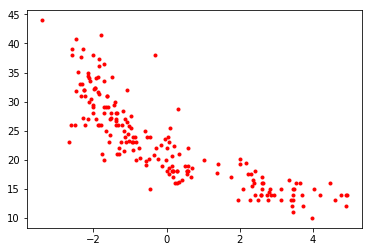

In [57]:
from matplotlib import pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.plot(X_train_new[:, 0], y_train, 'r.');

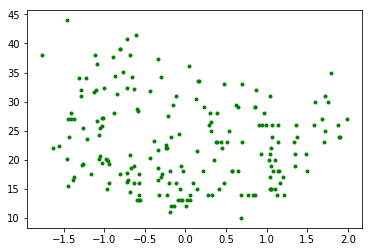

In [58]:
fig, ax = plt.subplots()
ax.plot(X_train_new[:, 1], y_train, 'g.');

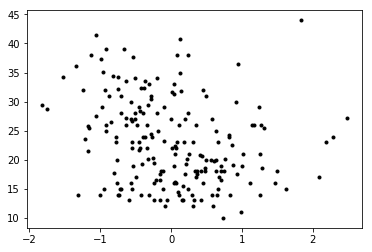

In [59]:
fig, ax = plt.subplots()
ax.plot(X_train_new[:, 2], y_train, 'k.');

Question: Is the first principal component the same line we would get if we constructed an ordinary least-squares regression line?

The answer is NO! Check out this post for an illuminating discussion: https://shankarmsy.github.io/posts/pca-vs-lr.html

## Modeling with New Dimensions

Now that we have optimized our features, we can build a new model with them!

In [38]:
lr_pca = LinearRegression()
lr_pca.fit(X_train_new, y_train)
lr_pca.score(X_train_new, y_train)

0.7892176900188986

In [40]:
X_test_new = pca.transform(test_scaled)

In [41]:
lr_pca.score(X_test_new, y_test)

0.7095548918693229

In [42]:
lr_pca.coef_

array([-3.00386437, -1.14559729, -2.48696878])

Thus, our best-fit hyperplane is given by:

$-3.00\times PC1 - 1.15\times PC2 -2.49\times PC3$

Of course, since the principal components are just linear combinations of our original predictors, we could re-express this hyperplane in terms of those original predictors!

And if the PCA was worth anything, we should expect the new linear model to be *different from* the first!

Recall that we had:

**PC1** = 0.454 * cylinders + 0.470 * cubicinches + 0.462 * hp + 0.440 * weightlbs - 0.357 * time-to-60 - 0.196 * year

**PC2** = -0.143 * cylinders - 0.110 * cubicinches - 0.023 * hp - 0.217 * weightlbs - 0.102 * time-to-60 - 0.954 * year

**PC3** = 0.204 * cylinders + 0.153 * cubicinches - 0.129 * hp + 0.361 * weightlbs + 0.860 * time-to-60 - 0.219 * year

Therefore, our new PCA-made hyperplane can be expressed as:

$-3.00\times(0.454\times cyl + 0.470\times in^3 + 0.462\times hp + 0.440\times lbs. - 0.357\times time_{60} - 0.196\times yr)$ <br/> $- 1.15\times(-0.143\times cyl - 0.110\times in^3 - 0.023\times hp - 0.217\times lbs. - 0.102\times time_{60} - 0.954\times yr)$ <br/> $- 2.49\times(0.204\times cyl + 0.153\times in^3 - 0.129\times hp + 0.361\times lbs. + 0.860\times time_{60} - 0.219\times yr)$ <br/><br/> $= -1.706\times cyl - 1.664\times in^3 -1.038\times hp - 1.969\times lbs. -0.953\times time_{60} + 2.230\times yr$

Our first linear regression model had:

$-1.409\times cyl + 0.681\times in^3 - 0.480\times hp - 4.658\times lbs. -  0.176\times time_{60} + 2.427\times yr$,

which is clearly a different hyperplane.